# **Capstone Project - The Battle of the Neighborhoods**

## Table of Contents:
* [Introduction](#business)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

----
#  **Introduction - Business Problem** <a class="anchor" id="business"></a>

> # Rental House Recommendation


> ### A real estate agent received a request from a client stating that they were looking for a rental property. However, this customer is from another region of Brazil and is moving to a new city so he does not know the neighborhoods and other characteristics of the new city.
> ### The Client made some demands for the broker, the neighborhood should have a good infrastructure and be well served by venues such as Bakeries, Restaurants, Pharmacys, Plaza.
> ### In addition, the neighborhood should have the highest possible population density x per capita income ratio to suit its financial reality.

In [ ]:
!pip install unidecode
!pip install folium

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library
import unidecode
import requests
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Libraries importing, done!')

Libraries importing, done!


In [3]:
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.geocode("Fanny, Curitiba")

In [5]:
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("-25.43397945, -49.25474350044901")
print(location.address)

161, Rua José de Alencar, Cristo Rei, Curitiba, Microrregião de Curitiba, Região Metropolitana de Curitiba, Mesorregião Metropolitana de Curitiba, Paraná, Região Sul, 80050-250, Brasil


In [6]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from lxml import html

----
# **Data** <a class="anchor" id="data"></a>

> ### For the analysis it is necessary a data source that provides all neighborhoods for the city of Curitiba - PR - Brazil.
> ### The means of obtaining this data is by scraping data from a website that presents characteristics of the city of Curitiba. In addition, it is also necessary to obtain statistical information on the neighborhoods, for example, number of inhabitants, size, average salary, etc.
> ### That said, for all neighborhoods, we must obtain Latitudes and Longitudes so that we can then submit this information to the Formsquare API and obtain venues in the vicinity of neighborhoods.
> ### After getting all the data consolidated then the data is submitted data cleaning step. Right after we analyzed the data using descriptive statistics.
> ### With the information, we select only the neighborhoods that have venues according to the client's requirements, and then order the neighborhoods according to the requirement of the density x montly income.

In [7]:
#Fetch wikipedia page as html
url = 'http://www.curitiba-parana.net/bairros.htm'
pageContent=requests.get(url)
neighborhood_html = html.fromstring(pageContent.content)

In [192]:
rows = neighborhood_html.xpath('//*[@id="table8"]')

In [193]:
neighborhood = []
for row in rows:
    for c1 in row:        
        for c2 in c1:            
            for c3 in c2:
                for c4 in c3:
                    if c4.text.rstrip() != '':
                        #print(c4.text)
                        neighborhood.append(c4.text)

In [135]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geo=[]
for n in set(neighborhood):
    val = n+', Curitiba'    
    location = geolocator.geocode(val)
    geo.append( (location[1][0], location[1][1],n))

In [200]:
import pandas as pd
df_geo = pd.DataFrame(geo, columns=['Lat', 'Long', 'Neighborhood'])

In [201]:
df_geo['Neighborhood'] = [ unidecode.unidecode(str(x).lower())  for x in df_geo['Neighborhood'].values if len(x) > 1]

In [203]:
df_geo.to_csv('curitiba_neigh_geo.csv', encoding="utf-8")

# Neighborhood Statistics

In [204]:
#Fetch wikipedia page as html
url = 'https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Curitiba'
pageContent=requests.get(url)
neigh_stats_html = html.fromstring(pageContent.content)

In [205]:
rows = neigh_stats_html.xpath('//*[@class="wikitable"]')

In [206]:
import re
import unicodedata 
arr=[]
arr_excluir = ['Bairros', 'oficiais']
for tb in rows:    
    for td in tb:        
        for val in td:            
            for v in val:                
                if (v.tag == 'td' and v.tag != 'None' and set(arr_excluir).issubset(set(v.text_content().split())) == False) :                    
                    arr.append(unicodedata.normalize("NFKD", v.text_content().rstrip()))


In [207]:
curitiba_neigh_stats = pd.DataFrame([arr[i*7:(i+1)*7] for i in range(len(arr)//7)])
curitiba_neigh_stats.columns = ['Neighborhood', 'Area_km2','Pop_Man', 'Pop_Woman','Pop_Total', 'Private_Houses', 'Montly_income']
curitiba_neigh_stats.drop_duplicates(subset ="Neighborhood", keep = False, inplace = True) 

In [208]:
curitiba_neigh_stats['Neighborhood'] = [ unidecode.unidecode(str(x).lower())  for x in curitiba_neigh_stats['Neighborhood'].values if len(x) > 1]
curitiba_neigh_stats['Area_km2'] = [str(x).replace(' ', '').replace(',','.') for x in curitiba_neigh_stats['Area_km2'].values if len(x) > 1]
curitiba_neigh_stats['Pop_Man'] = [str(x).replace(' ', '').replace(',','.') for x in curitiba_neigh_stats['Pop_Man'].values if len(x) > 1]
curitiba_neigh_stats['Pop_Woman'] = [str(x).replace(' ', '').replace(',','.') for x in curitiba_neigh_stats['Pop_Woman'].values if len(x) > 1]
curitiba_neigh_stats['Pop_Total'] = [str(x).replace(' ', '').replace(',','.') for x in curitiba_neigh_stats['Pop_Total'].values if len(x) > 1]
curitiba_neigh_stats['Private_Houses'] = [str(x).replace(' ', '').replace(',','.') for x in curitiba_neigh_stats['Private_Houses'].values if len(x) > 1]
curitiba_neigh_stats['Montly_income'] = [str(x).replace(' ', '').replace(',','.') for x in curitiba_neigh_stats['Montly_income'].values if len(x) > 1]

In [209]:
curitiba_neigh_stats.head()

,Neighborhood,Area_km2,Pop_Man,Pop_Woman,Pop_Total,Private_Houses,Montly_income
0,ganchinho,11.20,3667,3658,7325,1921,767.35
1,sitio cercado,11.12,50631,51779,102410,27914,934.95
2,umbara,22.47,7280,7315,14595,17064,908.70
3,abranches,4.32,5463,5702,11165,3154,1009.67
4,atuba,4.27,6156,6476,12632,3627,1211.60


In [210]:
curitiba_neigh_stats.to_csv('curitiba_neigh_stats.csv', encoding="utf-8")

In [3]:
df_ctba_geo = pd.read_csv('df_ctba_geo.csv', encoding='utf8', index_col=0)

In [4]:
df_ctba_geo.head()

,Neighborhood,Area_km2,Pop_Man,Pop_Woman,Pop_Total,Private_Houses,Montly_income,Lat,Long
0,ganchinho,11.20,3667,3658,7325,1921,767.35,-25.572076,-49.263667
1,sitio cercado,11.12,50631,51779,102410,27914,934.95,-25.542701,-49.269106
2,umbara,22.47,7280,7315,14595,17064,908.70,-25.568169,-49.285699
3,abranches,4.32,5463,5702,11165,3154,1009.67,-25.361474,-49.272054
4,atuba,4.27,6156,6476,12632,3627,1211.60,-25.387500,-49.206606


### Geting Curitiba Lat Long using geopy

In [5]:
address = 'Curitiba, Parana'
geolocator = Nominatim(user_agent="curitiba_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Curitiba are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Curitiba are -25.4295963, -49.2712724.


### Visualize Curitiba Neighborhood

In [6]:
map_curitiba = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_ctba_geo['Lat'], df_ctba_geo['Long'], df_ctba_geo['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_curitiba)  
    
map_curitiba

In [216]:
# alto da xv , boa vista e cachoeira autiliers

----
# **Methodology** <a class="anchor" id="methodology"></a>

> ### Merge data from differente site which was obtained using scraping. This merge will provida full data set of Curitiba's neghborhood and also some statistics.
> ### Get all the coordinates Lat and Log for each neighborhood.
> ### Using Lat and Long of each neighborhood, trigger the foursquare API and get the venues of each neighborhood.
> ### Filter the neighborhood to get only neighborhood that have all the venues that the Client desire.
> ### Provide a final answer geeting a list of the possible neighbor base on the lower density with high montly income


### Analysing the neighborhood

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
df_ctba_geo = df_ctba_geo.reset_index()
df_ctba_geo.drop('index', axis = 1, inplace=True)
df_ctba_geo.head()

,Neighborhood,Area_km2,Pop_Man,Pop_Woman,Pop_Total,Private_Houses,Montly_income,Lat,Long
0,ganchinho,11.20,3667,3658,7325,1921,767.35,-25.572076,-49.263667
1,sitio cercado,11.12,50631,51779,102410,27914,934.95,-25.542701,-49.269106
2,umbara,22.47,7280,7315,14595,17064,908.70,-25.568169,-49.285699
3,abranches,4.32,5463,5702,11165,3154,1009.67,-25.361474,-49.272054
4,atuba,4.27,6156,6476,12632,3627,1211.60,-25.387500,-49.206606


In [16]:
df_ctba_geo[df_ctba_geo['Neighborhood'] == 'cristo rei' ]

,Neighborhood,Area_km2,Pop_Man,Pop_Woman,Pop_Total,Private_Houses,Montly_income,Lat,Long
47,cristo rei,1.46,6147,7178,13325,5128,2603.13,-25.433646,-49.244579


In [17]:
neighborhood_latitude = df_ctba_geo.loc[47, 'Lat'] # neighborhood latitude value
neighborhood_longitude = df_ctba_geo.loc[47, 'Long'] # neighborhood longitude value

neighborhood_name = df_ctba_geo.loc[47, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of cristo rei are -25.4336461, -49.2445794.


In [18]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Reading consolidated Data

In [3]:
curitiba_venues = pd.read_csv('curitiba_venues.csv', encoding='utf8', index_col=0)

In [4]:
print(curitiba_venues.shape)
curitiba_venues.head()

(1325, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ganchinho,-25.572076,-49.263667,Ônibus Ganchinho,-25.572466,-49.261480,Moving Target
1,ganchinho,-25.572076,-49.263667,Grêmio Esportivo Recreativo do Ganchinho,-25.574583,-49.261920,Soccer Field
2,ganchinho,-25.572076,-49.263667,Defumados Ganchinho,-25.569211,-49.265118,Steakhouse
3,ganchinho,-25.572076,-49.263667,Bistrô Lago Azul,-25.573259,-49.267888,Brazilian Restaurant
4,ganchinho,-25.572076,-49.263667,Jardim Recanto Feliz,-25.568017,-49.264192,Housing Development


In [6]:
#toronto_venues.groupby('Neighborhood').count()
#curitiba_venues[curitiba_venues['Venue Category']=='Pizza Place']#.value_counts()
curitiba_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
abranches,3,3,3,3,3,3
agua verde,33,33,33,33,33,33
ahu,22,22,22,22,22,22
alto boqueirao,8,8,8,8,8,8
alto da gloria,38,38,38,38,38,38


In [7]:
ctb_neigh_venue = curitiba_venues[['Neighborhood', 'Venue']].copy()

In [8]:
ctb_neigh_venue = ctb_neigh_venue.groupby(['Neighborhood']).size().reset_index(name='Venues')

In [9]:
ctb_neigh_venue.head()

,Neighborhood,Venues
0,abranches,3
1,agua verde,33
2,ahu,22
3,alto boqueirao,8
4,alto da gloria,38


# Top 10 Neighborhood with more venues

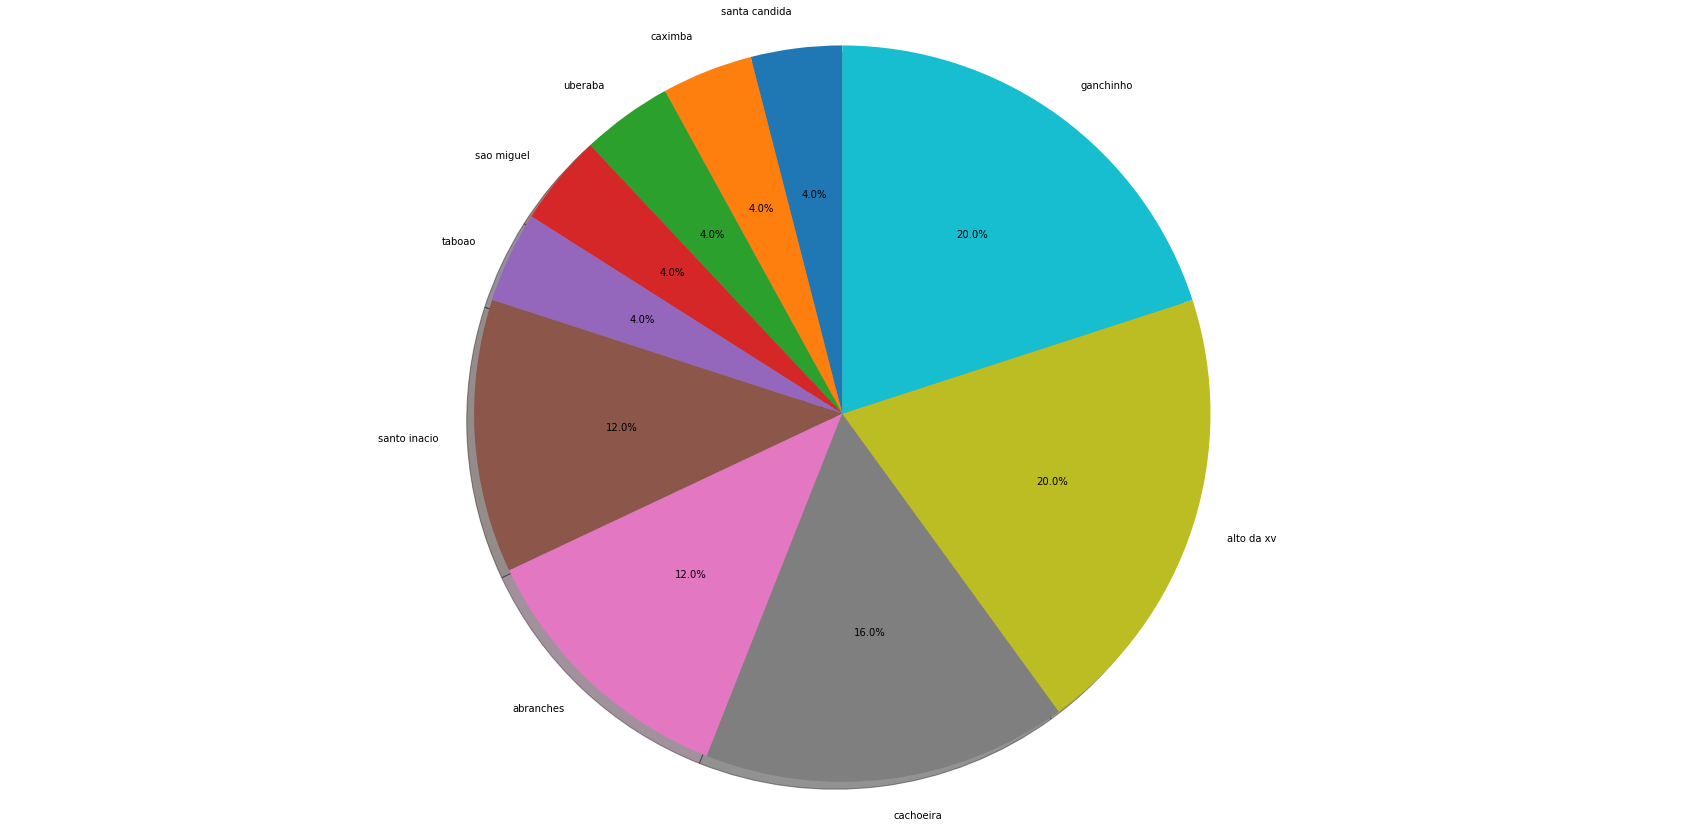

In [10]:
import matplotlib.pyplot as plt
df_pie = ctb_neigh_venue.sort_values(by='Venues', ascending=True).head(10)
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df_pie['Neighborhood']
sizes = df_pie['Venues']
explode = np.zeros(len(df_pie['Neighborhood'])) # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(30,15))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [11]:
del ctb_neigh_venue, df_pie

In [14]:
print('There are {} uniques categories.'.format(len(curitiba_venues['Venue Category'].unique())))

There are 222 uniques categories.


# Analysing the neighborhood

In [26]:
# one hot encoding
curitiba_onehot = pd.get_dummies(curitiba_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
curitiba_onehot['Neighborhood'] = curitiba_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [curitiba_onehot.columns[-1]] + list(curitiba_onehot.columns[:-1])
curitiba_onehot = curitiba_onehot[fixed_columns]

curitiba_onehot.head()

,Yoga Studio,Acai House,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Carpet Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Health Food Store,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Housing Development,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Leather Goods Store,Library,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Venue,Neighborhood,Nightclub,Office,Paintball Field,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Pet Store,Pharmacy,Photography Lab,Piano Bar,Pie Shop,Pizza Place,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Recording Studio,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern Brazilian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Street Fair,Supermarket,Sushi Restaurant,Tailor Shop,Tattoo Parlor,Tea Room,Tennis Court,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Track,Used Bookstore,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Warehouse Store,Water Park,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,ganchinho,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ganchinho,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [29]:
curitiba_onehot.shape

(1336, 221)

### Lets group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [31]:
curitiba_grouped = curitiba_onehot.groupby('Neighborhood').mean().reset_index()
curitiba_grouped.head()

,Neighborhood,Yoga Studio,Acai House,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Carpet Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Health Food Store,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Housing Development,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Leather Goods Store,Library,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nightclub,Office,Paintball Field,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Pet Store,Pharmacy,Photography Lab,Piano Bar,Pie Shop,Pizza Place,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Recording Studio,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern Brazilian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Street Fair,Supermarket,Sushi Restaurant,Tailor Shop,Tattoo Parlor,Tea Room,Tennis Court,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Track,Used Bookstore,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Warehouse Store,Water Park,Wine Bar,Wine Shop,Women's Store
0,abranches,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.

In [32]:
curitiba_grouped.shape

(64, 221)

### Printing the neighbors

In [33]:
num_top_venues = 5

for hood in curitiba_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = curitiba_grouped[curitiba_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----abranches----
                 venue  freq
0         Concert Hall  0.25
1         Soccer Field  0.25
2                 Farm  0.25
3  Sporting Goods Shop  0.25
4          Yoga Studio  0.00


----agua verde----
                  venue  freq
0  Brazilian Restaurant  0.10
1           Pizza Place  0.10
2            Beer Store  0.06
3         Hot Dog Joint  0.03
4                 Diner  0.03


----ahu----
           venue  freq
0     Restaurant  0.14
1    Pizza Place  0.09
2     Steakhouse  0.09
3  Hot Dog Joint  0.05
4            Bar  0.05


----alto boqueirao----
                  venue  freq
0     Mobile Phone Shop  0.25
1        Sandwich Place  0.25
2           Supermarket  0.25
3  Gym / Fitness Center  0.25
4           Yoga Studio  0.00


----alto da gloria----
                  venue  freq
0                  Café  0.11
1        Chocolate Shop  0.05
2  Brazilian Restaurant  0.05
3                Buffet  0.05
4           Coffee Shop  0.05


----alto da xv----
           venue  freq
0

### Creating a dataframe to show data in descendent order

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Top 10 revenues

In [81]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = curitiba_grouped['Neighborhood']

for ind in np.arange(curitiba_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(curitiba_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,abranches,Sporting Goods Shop,Concert Hall,Soccer Field,Farm,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
1,agua verde,Pizza Place,Brazilian Restaurant,Beer Store,Beer Bar,Breakfast Spot,Sushi Restaurant,Restaurant,Big Box Store,Lottery Retailer,Dance Studio
2,ahu,Restaurant,Pizza Place,Steakhouse,Flower Shop,Plaza,Café,Sandwich Place,Bar,Chinese Restaurant,BBQ Joint
3,alto boqueirao,Mobile Phone Shop,Gym / Fitness Center,Sandwich Place,Supermarket,Empanada Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
4,alto da gloria,Café,Brazilian Restaurant,Soccer Stadium,Buffet,Chocolate Shop,Coffee Shop,Yoga Studio,Portuguese Restaurant,Chinese Restaurant,Clothing Store


### Cluster neighborhoods

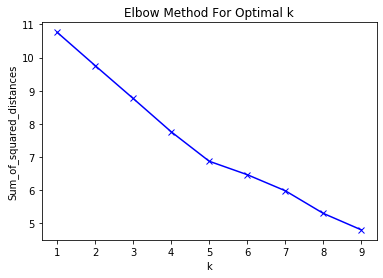

In [42]:
Sum_of_squared_distances = []
curitiba_grouped_clustering = curitiba_grouped.drop('Neighborhood', 1)
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(curitiba_grouped_clustering) #KMeans(n_clusters=k)
    #km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()    

In [127]:
# set number of clusters
kclusters = 10

curitiba_grouped_clustering = curitiba_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(curitiba_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:60] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 3, 0, 0, 8, 1, 2,
       0, 0, 0, 0, 8, 8, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 9, 0, 0, 0, 6, 0, 8, 7, 0, 8, 5])

### Creating a new dataframe that includes the cluster as well as the top 10 venues

In [128]:
curitiba_merged['Cluster Labels'].value_counts()

curitiba_merged[curitiba_merged['Cluster Labels'].isnull()]#.values.any()

,Neighborhood,Area_km2,Pop_Man,Pop_Woman,Pop_Total,Private_Houses,Montly_income,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [129]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1, inplace=True)
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
    
curitiba_merged = df_t

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
curitiba_merged = curitiba_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

curitiba_merged.fillna(0.0,inplace=True)

curitiba_merged['Cluster Labels']= curitiba_merged['Cluster Labels'].apply(np.int64)
    
    
curitiba_merged.head() # check the last columns!

,Neighborhood,Area_km2,Pop_Man,Pop_Woman,Pop_Total,Private_Houses,Montly_income,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ganchinho,11.20,3667,3658,7325,1921,767.35,-25.572076,-49.263667,0,Housing Development,Soccer Field,Steakhouse,Moving Target,Brazilian Restaurant,Women's Store,Event Space,Flea Market,Fish Market,Fish & Chips Shop
1,sitio cercado,11.12,50631,51779,102410,27914,934.95,-25.542701,-49.269106,8,Bakery,Pizza Place,Supermarket,Women's Store,Event Service,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant
2,umbara,22.47,7280,7315,14595,17064,908.70,-25.568169,-49.285699,0,Electronics Store,Video Store,Bakery,Gym / Fitness Center,Bar,Supermarket,Exhibit,Fabric Shop,Farm,Women's Store
3,abranches,4.32,5463,5702,11165,3154,1009.67,-25.361474,-49.272054,0,Sporting Goods Shop,Concert Hall,Soccer Field,Farm,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
4,atuba,4.27,6156,6476,12632,3627,1211.60,-25.387500,-49.206606,0,Café,Food,Sports Bar,Warehouse Store,Restaurant,Empanada Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant


In [133]:
curitiba_merged['Cluster Labels'].value_counts()

0    54
8     7
9     1
7     1
6     1
5     1
4     1
3     1
2     1
1     1
Name: Cluster Labels, dtype: int64

### Creating a new dataframe that includes the cluster as well as the top 10 venues

In [130]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(curitiba_merged['Lat'], curitiba_merged['Long'], curitiba_merged['Neighborhood'], curitiba_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Now, Lets identify the top neighborhoods for our Client based on his requirements

### First, the client whants that a neighborhood should has Bakery, Resutants, Pharmacys, Plazas 

In [76]:
curitiba_venues = pd.read_csv('curitiba_venues.csv', encoding='utf8', index_col=0)

In [77]:
arr_bakery = curitiba_venues[curitiba_venues['Venue Category'].str.contains("Bakery")]['Neighborhood'].unique()
arr_restaurant = curitiba_venues[curitiba_venues['Venue Category'].str.contains("Restaurant")]['Neighborhood'].unique()
arr_pharmacy = curitiba_venues[curitiba_venues['Venue Category'].str.contains("Pharmacy")]['Neighborhood'].unique()
arr_plaza = curitiba_venues[curitiba_venues['Venue Category'].str.contains("Plaza")]['Neighborhood'].unique()
#neigh_filtered = list(set().union(arr_bakery, arr_restaurant, arr_pharmacy, arr_plaza, arr_bus))
neigh_list = list(set(arr_bakery).intersection(arr_restaurant, arr_pharmacy, arr_plaza))

In [79]:
neigh_list

['juveve', 'batel']

In [80]:
curitiba_neigh_stats = pd.read_csv('curitiba_neigh_stats.csv', encoding='utf8', index_col=0)

In [82]:
neigh_filtered = curitiba_neigh_stats[curitiba_neigh_stats['Neighborhood'].isin(neigh_list)] #.sort_values(by='Montly_income', ascending=False).head(5)

In [88]:
neigh_filtered

,Neighborhood,Area_km2,Pop_Man,Pop_Woman,Pop_Total,Private_Houses,Montly_income
43,batel,1.76,5126,6652,11778,3938,5120.73
53,juveve,1.23,4995,6286,11281,3994,3435.48


In [104]:
neigh_filtered['density'] = neigh_filtered.apply(lambda x: (x['Pop_Total']/ x['Area_km2'] ), axis=1) 

C:\Users\Marcio\Miniconda3\envs\data\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [107]:
neigh_filtered.sort_values(['Montly_income', 'density'], ascending=[False, True])['Neighborhood'].head()

43     batel
53    juveve
Name: Neighborhood, dtype: object

----
# **Results and Dicussion** <a class="anchor" id="results"></a>
> ### The client has high demands and it seems that Curitiba, which is not big city, has just a few neighborhoods to offer considering the clients demands. The real estate agent should offer house rentals of only two Curitiba's neighborhoods, which are, Batel and Juveve. By the way, these neighborhoods are the most rich neighborhoods.


----
# **Conclusion** <a class="anchor" id="conclusion"></a>
> ### This kind of data is not so difficult to get and not so difficult to interpret, but the issues that we may foud is a site on the web which is trustefull to get the information of the city because there are statiscal rates which should be provide from a reliable entity.
> ### Also, this kind of analysis may help the real state agents to provide an quick answer to clients when they have a bunch of variables to consider when searching for a rouse to offer to client. 